# Apply NORDic to the ``synthetic_random_diff3-1`` synthetic dataset

In [1]:
import NORDic
from IPython.display import Image
import pandas as pd

dataset_name = "synthetic_random_diff3-1"
pert_genes = ["x14", "x1", "x2", "x7", "x9"]

file_folder=f"{dataset_name}/"
seed_number=123456

In this case, we directly have access to binarized (Boolean) trajectories from an initial state to a single steady state (plus intermediary states, that will be ignored) for several synthetic KO experiments.

Let's convert this into a NORDic-compatible format.


## 0. Retrieve the data

In [2]:
import os
from subprocess import Popen

proc = Popen(f"mkdir -p {file_folder}".split(" "))
proc.wait()

data_url="https://raw.githubusercontent.com/gt-bioss/benchmark-dynamical-models/main/"
data_url+=f"from-boolean-networks/{dataset_name}/ground-truth/"

exp_list = ["wt-boolean-trajectories.csv"]+[
    "%sKO-boolean-trajectories.csv" % g
    for g in pert_genes
]

for exp in exp_list:
    proc = Popen(f"wget -O {file_folder}/{exp} -q {data_url}/{exp}".split(" "))
    proc.wait()
    df = pd.read_csv(f"{file_folder}/{exp}", sep=",", index_col=0)
    print(exp)
    print(df.head())
    gene_lst = list(df.columns)

wt-boolean-trajectories.csv
                   x0  x1  x10  x11  x12  x13  x14  x15  x16  x17  ...  x27  \
init                0   0    1    0    0    1    1    0    0    0  ...    1   
init_to_steady1_1   0   0    1    0    0    1    1    0    0    0  ...    1   
init_to_steady1_2   1   0    1    0    0    1    1    0    0    0  ...    1   
init_to_steady1_3   1   0    1    0    0    1    1    0    0    0  ...    1   
init_to_steady1_4   1   0    1    0    0    1    1    0    0    0  ...    1   

                   x28  x29  x3  x4  x5  x6  x7  x8  x9  
init                 0    1   1   1   1   1   0   0   0  
init_to_steady1_1    0    1   1   0   1   1   0   0   0  
init_to_steady1_2    0    1   1   0   1   1   0   0   0  
init_to_steady1_3    0    1   1   0   1   1   0   0   0  
init_to_steady1_4    0    1   1   0   1   1   0   0   0  

[5 rows x 30 columns]
x14KO-boolean-trajectories.csv
                   x0  x1  x10  x11  x12  x13  x14  x15  x16  x17  ...  x27  \
init            

## 1. Prior Knowledge Network

The dataset is synthetic, so there is no prior on the structure of the network. We then build a complete graph (to prevent the resort to the STRING database which will be otherwise useless).

In [3]:
NETWORK_fname = f"{file_folder}/complete_ppi.tsv"

## complete graph
all_pairs = [(g,gp) for ig, g in enumerate(gene_lst) for gp in gene_lst[(ig+1):]]
n = len(all_pairs)
PPI = pd.DataFrame([
    [g, gp, 2, 0, 0.5] ## build undirected unsigned edges with score=0.5
    for g, gp in all_pairs
], columns=["preferredName_A", "preferredName_B", "sign", "directed", "score"], index=range(n))
PPI.to_csv(NETWORK_fname, sep="\t", index=None)

PPI.head()

,preferredName_A,preferredName_B,sign,directed,score
0,x0,x1,2,0,0.5
1,x0,x10,2,0,0.5
2,x0,x11,2,0,0.5
3,x0,x12,2,0,0.5
4,x0,x13,2,0,0.5


## 2. Experimental file

We convert the Boolean trajectories that we retrieved into a format compatible with NORDic. For each retrieved experimental file (corresponding to a single (non)perturbation experiment):

- There is the Boolean state of the initial condition named ``init``
- We ignore intermediary states named ``init_to_steady1_*``
- There is the final steady state named ``steady1``

In [4]:
EXPERIMENTS_fname = f"{file_folder}/experiments.csv"
experiments = pd.DataFrame([], index=gene_lst+["annotation", "perturbed", "perturbation", "cell_line", "sigid"])
cell="".join(dataset_name.split("_")) ## no "_"

for ie, exp in enumerate(exp_list):
    df = pd.read_csv(f"{file_folder}/{exp}", sep=",", index_col=0)
    if ("wt-" in exp):
        experiments[f"initial_{cell}"] = df.loc["init"][gene_lst].values.flatten().tolist()+["1","None","None",cell,f"{exp}:init"]
        continue
    if ((len(exp.split("KO"))>2) or ("UP" in exp)):
        continue
    else:
        pert_gene = exp.split("KO")[0]
        pert_dir = "KD"
    exp_name = f"{pert_gene}_KD_"+cell
    steady_name = "steady" if ("steady" in df.index) else "steady1"
    experiments[exp_name] = df.loc[steady_name][gene_lst].values.flatten().tolist()+["2",pert_gene,pert_dir,cell,f"{exp}:steady"]
experiments.to_csv(EXPERIMENTS_fname, sep=",")

experiments.T.head()

,x0,x1,x10,x11,x12,x13,x14,x15,x16,x17,...,x5,x6,x7,x8,x9,annotation,perturbed,perturbation,cell_line,sigid
initial_syntheticrandomdiff3-1,0,0,1,0,0,1,1,0,0,0,...,1,1,0,0,0,1,None,None,syntheticrandomdiff3-1,wt-boolean-trajectories.csv:init
x14_KD_syntheticrandomdiff3-1,1,0,1,1,0,0,0,0,1,1,...,1,0,0,0,1,2,x14,KD,syntheticrandomdiff3-1,x14KO-boolean-trajectories.csv:steady
x1_KD_syntheticrandomdiff3-1,1,0,1,1,0,0,0,0,1,1,...,1,0,0,0,1,2,x1,KD,syntheticrandomdiff3-1,x1KO-boolean-trajectories.csv:steady
x2_KD_syntheticrandomdiff3-1,0,0,1,1,1,0,1,1,1,0,...,1,0,0,0,0,2,x2,KD,syntheticrandomdiff3-1,x2KO-boolean-trajectories.csv:steady
x7_KD_syntheticrandomdiff3-1,1,0,1,1,0,0,0,0,1,1,...,1,0,0,0,1,2,x7,KD,syntheticrandomdiff3-1,x7KO-boolean-trajectories.csv:steady


## 3. Parameters

Not needed, since both the PKN and the experiments are available from the start.

In [5]:
from multiprocessing import cpu_count
njobs=1

## Random
taxon_id=1111
disease_cids=["Unknown"] 
cell_lines=[cell]
path_to_genes=None

DisGeNET_credentials = ""
STRING_credentials = ""
LINCS_credentials = ""
DISGENET_args = {"credentials": DisGeNET_credentials, "disease_cids": disease_cids}
STRING_args = {"credentials": STRING_credentials, "score": 0}
EDGE_args = {"tau": None, "filter": False, "connected": False}
accept_nonRNA=True
preserve_network_sign=False
LINCS_args = {"path_to_lincs": "", 
              "credentials": LINCS_credentials,
              "cell_lines": cell_lines, "thres_iscale": None}
SIG_args = {"bin_thres": 0.5}
force_experiments=False
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Identification parameters
BONESIS_args = {"limit": 100, "exact": False, "max_maxclause": 1}

## 4. Network identification

In [6]:
from NORDic.NORDic_NI.functions import network_identification

solution = NORDic.NORDic_NI.functions.network_identification(
    file_folder, taxon_id, path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
    string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args,
    bonesis_args=BONESIS_args, weights=DESIRABILITY, experiments_fname=EXPERIMENTS_fname,
    seed=seed_number, network_fname=NETWORK_fname, njobs=njobs, force_experiments=force_experiments, 
    accept_nonRNA=accept_nonRNA, preserve_network_sign=preserve_network_sign)

100 solutions are already generated, and saved at synthetic_random_diff3-1/SOLUTIONS-100_binthres=0.500_thresiscale=None_score=0.00_maxclause=1_{1,...1}.zip
--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...100 solutions (100 unique solutions)
... 100 solutions (10/31 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 8 edges
<MODEL VISUALIZATION> Maximal solution: 35 edges
          1         2        3         4         5         6         7    \
GTP  0.863681  0.870383  0.85169  0.857943  0.860424  0.854826  0.862331   

          8         9         10       11        12       13        14   \
GTP  0.854432  0.850094  0.863363  0.83956  0.867622  0.85591  0.872872   

          15        16        17      18        19        20        21   \
GTP  0.876584  0.842547  0.874981  0.8725  0.867887  0.845996  0.854163   

          22        23        24        25       26        27        28   \
GTP  0.862455  0.873937  

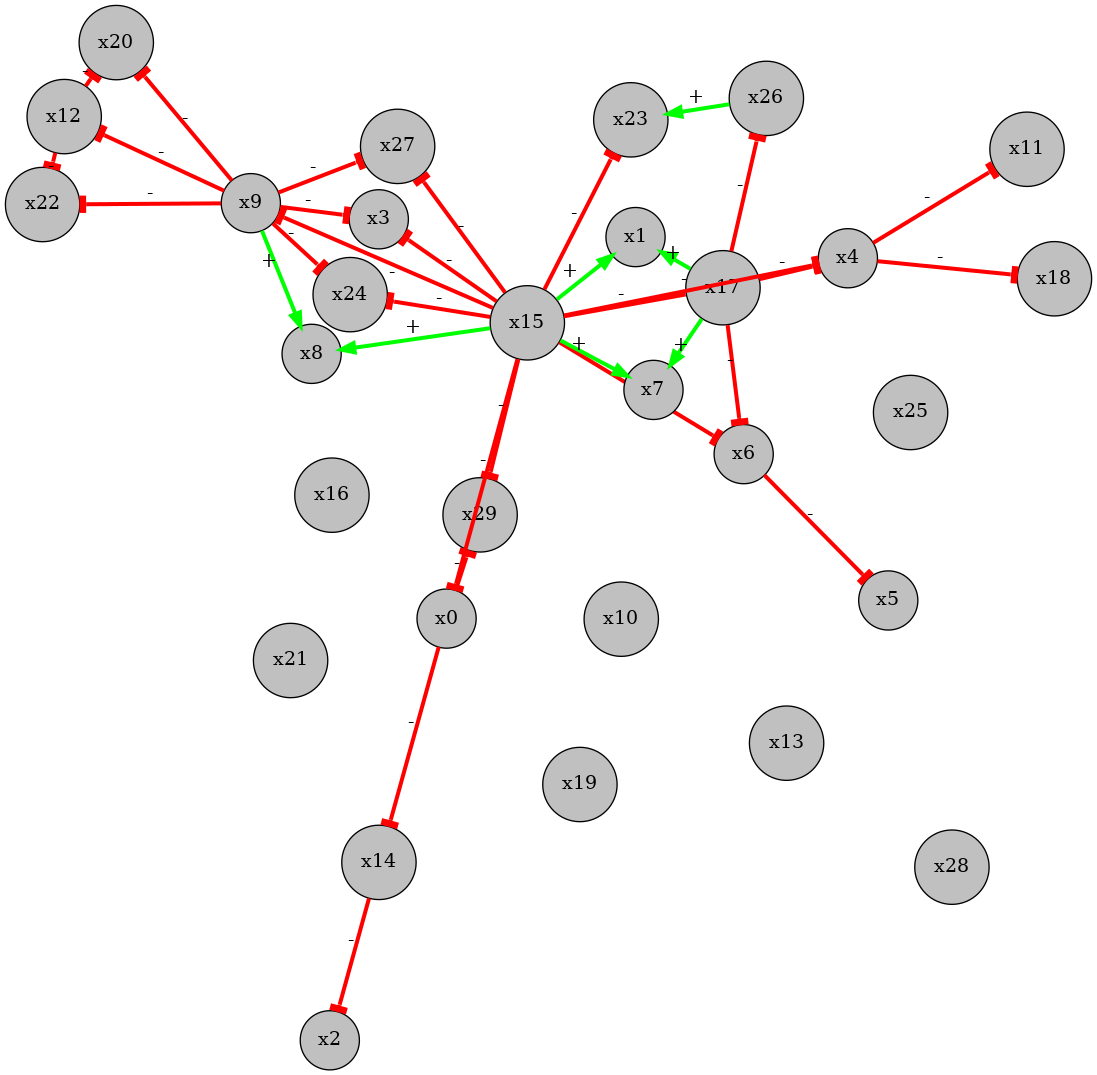

In [7]:
from IPython.display import Image
Image(filename=f'{file_folder}/inferred_max_criterion_solution.png') 

In [8]:
pd.read_csv(f"{file_folder}/GPT.csv", index_col=0).T.sort_values(by="GTP", ascending=False)

,GTP
84,0.887459
79,0.880147
65,0.877925
83,0.877719
29,0.877292
...,...
36,0.838651
27,0.836758
33,0.836531
91,0.832980


## 5. Ground truth network

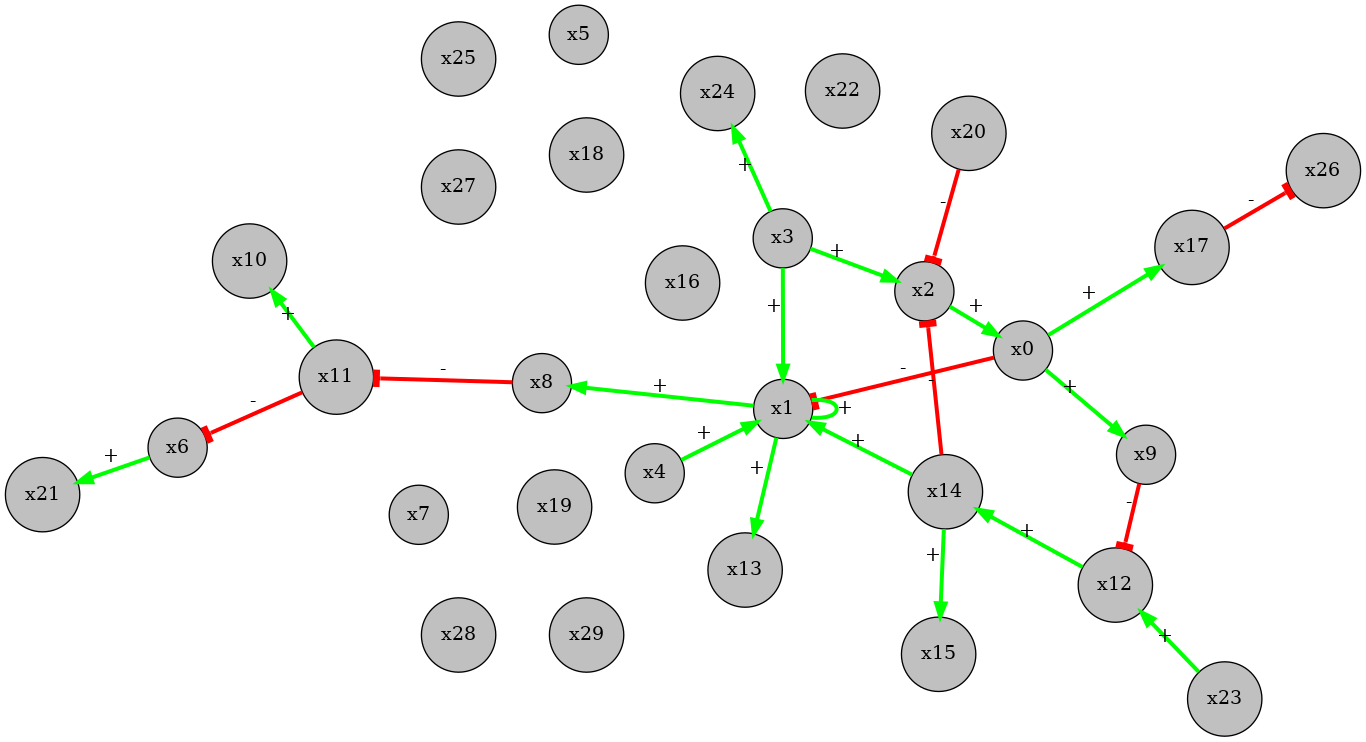

In [9]:
network_fname="boolean-network.bnet"
proc = Popen(f"wget -O {file_folder}/{network_fname} -q {data_url}/{network_fname}".split(" "))
proc.wait()

from NORDic.UTILS.utils_grn import solution2influences
from NORDic.UTILS.utils_plot import influences2graph

with open(f"{file_folder}/{network_fname}", "r") as f:
    ground_truth = pd.DataFrame({
        "Solution": dict([["_".join(g.split("-")) for g in x.split(", ")] for x in f.read().split("\n") if (len(x)>0)])
    })
influences_ground_truth = solution2influences(ground_truth["Solution"])
influences2graph(influences_ground_truth, file_folder+"ground_truth", optional=False, compile2png=True, engine=["sfdp","dot"][0])
from IPython.display import Image
Image(filename=file_folder+'ground_truth.png') 